# JPEG ENCODING

## Loading modules and image

In [494]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
# Load image
num_co=28
block_size=8
img_name='brain_398.tif'
img = cv2.imread(img_name)
height, width, channels = img.shape

## Adding zero padding in the image

In [495]:
padding_h=0
padding_w=0
if(height%block_size!=0):
    padding_h =block_size - height %block_size
if(width%block_size!=0):
    padding_w =block_size - width %block_size
padded_array = np.zeros((height + padding_h, width + padding_w,3), dtype=np.uint8)
padded_array[:height, :width, :] = img
img=padded_array
height, width, channels = img.shape
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
y,u,v=cv2.split(img_yuv)


## Defining QY and QUV standard matrices for default block size of 8 cross 8

In [496]:
QY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
               [12, 12, 14, 19, 26, 58, 60, 55],
               [14, 13, 16, 24, 40, 57, 69, 56],
               [14, 17, 22, 29, 51, 87, 80, 62],
               [18, 22, 37, 56, 68, 109, 103, 77],
               [24, 35, 55, 64, 81, 104, 113, 92],
               [49, 64, 78, 87, 103, 121, 120, 101],
               [72, 92, 95, 98, 112, 100, 103, 99]])

QUV = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
               [18, 21, 26, 66, 99, 99, 99, 99],
               [24, 26, 56, 99, 99, 99, 99, 99],
               [47, 66, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99],
               [99, 99, 99, 99, 99, 99, 99, 99]])

## Taking the DCT and then converting them into quantization matrices

In [497]:
dct_y=np.zeros(y.shape)
dct_u=np.zeros(u.shape)
dct_v=np.zeros(v.shape)
for i in range(0,y.shape[0],block_size):
    for j in range(0,y.shape[1],block_size):
        dct_y[i:i+block_size,j:j+block_size]=cv2.dct(np.float32(y[i:i+block_size,j:j+block_size]))
        dct_u[i:i+block_size, j:j+block_size] = cv2.dct(np.float32(u[i:i+block_size, j:j+block_size]))
        dct_v[i:i+block_size, j:j+block_size] = cv2.dct(np.float32(v[i:i+block_size, j:j+block_size]))

quantized_y=np.zeros(y.shape)
quantized_u=np.zeros(u.shape)
quantized_v=np.zeros(v.shape)
for i in range(0,y.shape[0],block_size):
    for j in range(0,y.shape[1],block_size):
        quantized_y[i:i+block_size,j:j+block_size]=np.round(dct_y[i:i+block_size,j:j+block_size]/QY)
        quantized_u[i:i+8,j:j+block_size]=np.round(dct_u[i:i+block_size,j:j+block_size]/QUV)
        quantized_v[i:i+block_size,j:j+block_size]=np.round(dct_v[i:i+block_size,j:j+block_size]/QUV)    


## Defining function for zig-zag conversion of 2D matrix

In [498]:
def zigzag_converter(matrix,num_coeffs=num_co,block_size=8,height=height,width=width):
    subarrays=matrix.reshape(height//block_size,block_size,width//block_size,block_size).swapaxes(1,2).reshape(-1,block_size,block_size)
    zigzag_patterns=[]
    for subarray in subarrays:
        zigzag_pattern = np.zeros((block_size * block_size,))
        index = 0
        for i in range(block_size):
            if i % 2 == 0:
                for j in range(i + 1):
                    row = i - j
                    col = j
                    if row < block_size and col < block_size:
                        zigzag_pattern[index] = subarray[row, col]
                        index += 1
            else:
                for j in range(i + 1):
                    row = j
                    col = i - j
                    if row < block_size and col < block_size:
                        zigzag_pattern[index] = subarray[row, col]
                        index += 1
        for i in range(1, block_size):
            if i % 2 == 0:
                for j in range(i, block_size):
                    row = block_size - j + i - 1
                    col = j
                    if row < block_size and col < block_size:
                        zigzag_pattern[index] = subarray[row, col]
                        index += 1
            else:
                for j in range(i, block_size):
                    row = j
                    col = block_size - j + i - 1
                    if row < block_size and col < block_size:
                        zigzag_pattern[index] = subarray[row, col]
                        index += 1
        zigzag_pattern[num_coeffs:]=0
        zigzag_patterns.append(zigzag_pattern)
        
    
    # Save the zigzag patterns in a 1D array
    zigzag_array = np.vstack(zigzag_patterns)
    # Set all coefficients after num_coeffs to zero
    return zigzag_array


### Converting the matrices into zigzag array of blocks

In [499]:
zigzag_y=zigzag_converter(matrix=quantized_y)
zigzag_u=zigzag_converter(matrix=quantized_u)
zigzag_v=zigzag_converter(matrix=quantized_v)

## Writing all data to file named with `output_jpeg_encoded.npy`

In [500]:
data={"filename":img_name,
      "block_size":block_size,
      "num_coeffs":num_co,
      "height":height,
      "width":width,
      "is_grayscale":True,
      "quantized_y":zigzag_y,
      "quantized_u":zigzag_u,
      "quantized_v":zigzag_v}
np.save('output_jpeg_encoded.npy', data)

## Calculations
* Total bits required to represent encoded matrix without removing trailing zeroes
* Calculating total number of bits required to represent our original image

In [501]:
quantized_array = np.concatenate((quantized_y.ravel(), quantized_u.ravel(), quantized_v.ravel()))

# Count the number of bits required to store each non-zero element
total_bits = 0
for element in quantized_array:
    if element != 0:
        total_bits += int(math.ceil(math.log2(abs(element) + 1)))
    else:
        total_bits+=1

print(f"Total number of bits required to represent encoded image withouting removing last zeroes: {total_bits}")
# Compute total number of bits required to store image
num_pixels = img.shape[0] * img.shape[1]
num_channels = img.shape[2]
total_bits_ = num_pixels * num_channels * 8

print(f"Total number of bits required to store image: {total_bits_}")
print(f"Compression Ratio:{total_bits_/total_bits} ")
Compression_Ratio_with_last_zeroes = total_bits_/total_bits
total_bitsx=total_bits

Total number of bits required to represent encoded image withouting removing last zeroes: 1159718
Total number of bits required to store image: 8432640
Compression Ratio:7.271284915815741 


## Calculations
* Total bits required to represent encoded matrix after removing trailing zeroes
* Calculating total number of bits required to represent our original image

In [502]:
total_bits=1
for i in range(len(zigzag_y)):
    temp=np.trim_zeros(zigzag_y[i])
    for elemnt in temp:
        if element != 0:
            total_bits += math.floor(math.log2(element))+1
        else:
            total_bits+=1
for i in range(len(zigzag_u)):
    temp=np.trim_zeros(zigzag_u[i])
    for elemnt in temp:
        if element != 0:
            total_bits += math.floor(math.log2(element))+1
        else:
            total_bits+=1
for i in range(len(zigzag_v)):
    temp=np.trim_zeros(zigzag_v[i])
    for elemnt in temp:
        if element != 0:
            total_bits += math.floor(math.log2(element))+1
        else:
            total_bits+=1


print(f"Total number of bits required to represent encoded image after removing last zeroes: {total_bits}")
# Compute total number of bits required to store image
num_pixels = img.shape[0] * img.shape[1]
num_channels = img.shape[2]
total_bits_ = num_pixels * num_channels * 8

print(f"Total number of bits required to store image: {total_bits_}")
print(f"Compression Ratio:{total_bits_/total_bits} ")
Compression_ratio_without_last_zeroes=total_bits_/total_bits
print(total_bits,total_bits_)


Total number of bits required to represent encoded image after removing last zeroes: 73314
Total number of bits required to store image: 8432640
Compression Ratio:115.02086913822735 
73314 8432640


# JPEG DECODING

## Loading all data written in `output_jpeg_encoded.npy`

In [503]:
loaded_data=np.load('output_jpeg_encoded.npy',allow_pickle=True).item()
quantized_y=loaded_data['quantized_y']
quantized_u=loaded_data['quantized_u']
quantized_v=loaded_data['quantized_v']
img_name=loaded_data['filename']
block_size=loaded_data['block_size']
is_grayscale=loaded_data['is_grayscale']
num_coeffs=loaded_data['num_coeffs']
height=loaded_data['height']
width=loaded_data['width']

## Defining our function to inverse the zigzag array into a 2D array

In [504]:
# Define the inverse zigzag pattern function
def inverse_zigzag_pattern(zigzag_pattern):
    # Get the size of the block
    block_size = int(np.sqrt(len(zigzag_pattern)))
    # Create an empty block
    block = np.zeros((block_size, block_size))
    # Initialize the indices for the first row and column
    i = 0
    j = 0
    # Loop through the zigzag pattern and fill in the block
    for k in range(len(zigzag_pattern)):
        block[i, j] = zigzag_pattern[k]
        # Move to the next row or column depending on the direction
        if (i + j) % 2 == 0:
            # Even direction (upwards)
            if j == block_size - 1:
                i += 1
            elif i == 0:
                j += 1
            else:
                i -= 1
                j += 1
        else:
            # Odd direction (downwards)
            if i == block_size - 1:
                j += 1
            elif j == 0:
                i += 1
            else:
                i += 1
                j -= 1
    # Return the block
    return block

### Converting zigzag y matrix into 2D matrix

In [505]:
subarrays = quantized_y.reshape(-1, block_size, block_size)
# Define the inverse zigzag pattern function for each subarray
inverse_zigzag_patterns = []
for subarray in subarrays:
    zigzag_pattern = inverse_zigzag_pattern(subarray.flatten())
    inverse_zigzag_patterns.append(zigzag_pattern)

num_blocks_x=int(height/block_size)
num_blocks_y=int(width/block_size)
# Reshape the inverse zigzag patterns into a matrix
quantized_y = np.block([[inverse_zigzag_patterns[i * num_blocks_y + j] for j in range(num_blocks_y)] for i in range(num_blocks_x)])

### Converting zigzag u matrix into 2D matrix

In [506]:
subarrays = quantized_u.reshape(-1, block_size, block_size)
# Define the inverse zigzag pattern function for each subarray
inverse_zigzag_patterns = []
for subarray in subarrays:
    zigzag_pattern = inverse_zigzag_pattern(subarray.flatten())
    inverse_zigzag_patterns.append(zigzag_pattern)

num_blocks_x=int(height/block_size)
num_blocks_y=int(width/block_size)
# Reshape the inverse zigzag patterns into a matrix
quantized_u = np.block([[inverse_zigzag_patterns[i * num_blocks_y + j] for j in range(num_blocks_y)] for i in range(num_blocks_x)])

### Converting zigzag v matrix into 2D matrix

In [507]:
subarrays = quantized_v.reshape(-1, block_size, block_size)
# Define the inverse zigzag pattern function for each subarray
inverse_zigzag_patterns = []
for subarray in subarrays:
    zigzag_pattern = inverse_zigzag_pattern(subarray.flatten())
    inverse_zigzag_patterns.append(zigzag_pattern)

num_blocks_x=int(height/block_size)
num_blocks_y=int(width/block_size)
# Reshape the inverse zigzag patterns into a matrix
quantized_v = np.block([[inverse_zigzag_patterns[i * num_blocks_y + j] for j in range(num_blocks_y)] for i in range(num_blocks_x)])

## Dequantizing the qunatized matrix and then applying IDCT

In [508]:
# (quantized_y, quantized_u, quantized_v) = np.load('output_jpeg_encoded.npy')
dequantized_y=np.zeros(quantized_y.shape)
dequantized_u=np.zeros(quantized_u.shape)
dequantized_v=np.zeros(quantized_v.shape)
for i in range(0,quantized_y.shape[0],block_size):
    for j in range(0,quantized_y.shape[1],block_size):
        dequantized_y[i:i+block_size,j:j+block_size]=quantized_y[i:i+block_size,j:j+block_size]*QY
        dequantized_u[i:i+block_size,j:j+block_size]=quantized_u[i:i+block_size,j:j+block_size]*QUV
        dequantized_v[i:i+block_size,j:j+block_size]=quantized_v[i:i+block_size,j:j+block_size]*QUV

idct_y = np.zeros(quantized_y.shape)
idct_u=np.zeros(quantized_u.shape)
idct_v=np.zeros(quantized_v.shape)
for i in range(0, quantized_y.shape[0], block_size):
    for j in range(0, quantized_y.shape[1], block_size):
        idct_y[i:i+block_size, j:j+block_size] = cv2.idct(np.float32(dequantized_y[i:i+block_size, j:j+block_size]))
        idct_u[i:i+block_size, j:j+block_size] = cv2.idct(np.float32(dequantized_u[i:i+block_size, j:j+block_size]))
        idct_v[i:i+block_size, j:j+block_size] = cv2.idct(np.float32(dequantized_v[i:i+block_size, j:j+block_size]))

## Merging y,u,v and then convert to RGB and save the image as `compressed_image.jpg`

In [509]:
# print(idct_y.shape)
idct_yuv = cv2.merge([idct_y, idct_u, idct_v])
compressed_img = cv2.cvtColor(cv2.convertScaleAbs(idct_yuv), cv2.COLOR_YUV2BGR)

### 1. Removing extra added padding from the image

In [510]:
cropped_image = compressed_img[padding_h:height, padding_w:width, :]

### 2. Saving the cropped image

In [511]:
cv2.imwrite('compressed_image.jpg', cropped_image)
cropped_image.shape

(486, 720, 3)

## Plotting all the required values

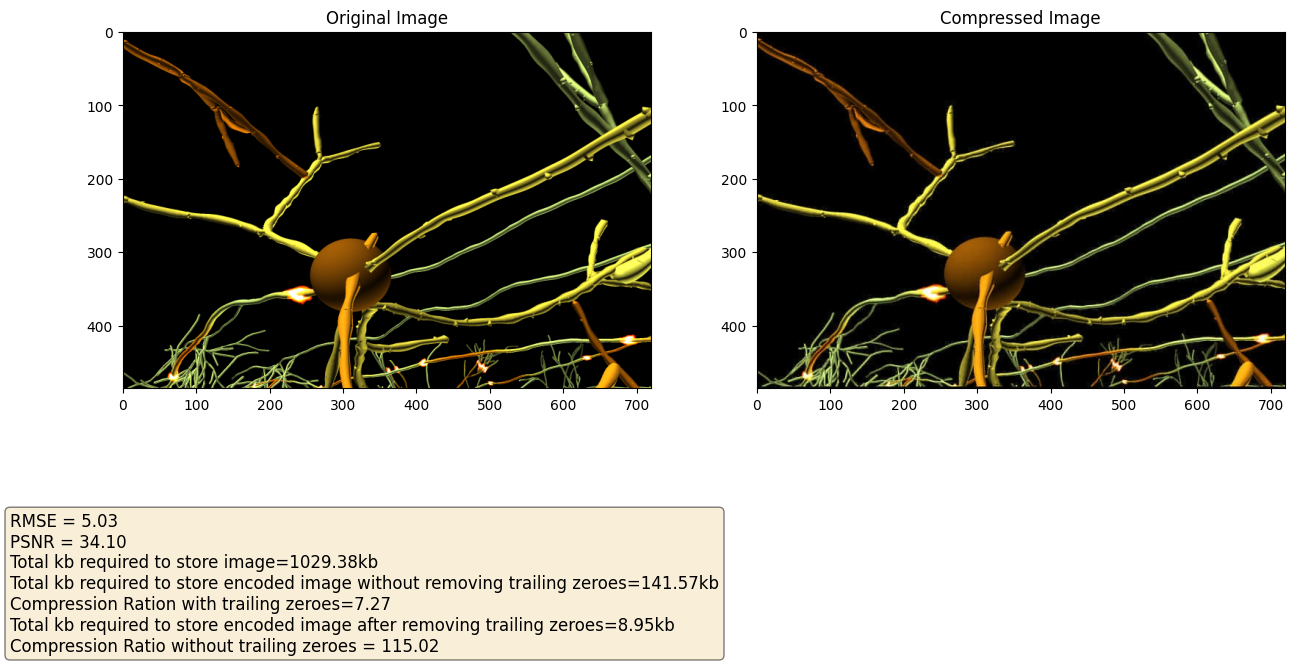

In [512]:
#printing the values
original_image=cv2.imread(img_name)
compressed_image=cv2.imread('compressed_image.jpg')
# Calculate the RMSE and PSNR between the original and compressed images
rmse = np.sqrt(np.mean((original_image - compressed_image)**2))
psnr = 20 * np.log10(255.0 / rmse)
# Calculate the compression ratio
original_size = original_image.shape[0] * original_image.shape[1]
compressed_size = compressed_image.shape[0] * compressed_image.shape[1]
compression_ratio = original_size / compressed_size

original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
compressed_image = cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB)
# Plot the original and compressed images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(original_image)
ax1.set_title('Original Image')
ax2.imshow(compressed_image)
ax2.set_title('Compressed Image')
# Add a text box with the RMSE, PSNR, and compression ratio
textstr = f'RMSE = {rmse:.2f}\nPSNR = {psnr:.2f}\nTotal kb required to store image={total_bits_/(1024*8):.2f}kb\nTotal kb required to store encoded image without removing trailing zeroes={total_bitsx/(1024*8):.2f}kb\nCompression Ration with trailing zeroes={Compression_Ratio_with_last_zeroes:.2f}\nTotal kb required to store encoded image after removing trailing zeroes={total_bits/(1024*8):.2f}kb\nCompression Ratio without trailing zeroes = {Compression_ratio_without_last_zeroes:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig.text(0.05, 0.05, textstr, fontsize=12, verticalalignment='bottom', bbox=props)
plt.show()